## QUESTION:
ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, you're tasked with creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction

In [1]:
#restart the kernel after installation
!pip install pandas-profiling --quiet

In [2]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

In [7]:
from urllib.request import urlretrieve

In [8]:
urlretrieve(medical_charges_url, 'medical.csv')

('medical.csv', <http.client.HTTPMessage at 0x1a873db23d0>)

In [9]:
import pandas as pd

In [10]:
medical_df = pd.read_csv('medical.csv')

In [11]:
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [12]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


It appears "age", "children", "bmi" (body mass index) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [13]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. 
The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.



EXERCISE: What other inferences can you draw by looking at the table above? Add your inferences below:

???
???
???
???
???

## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization. Follow these tutorials to learn how to use these libraries: 

- https://jovian.ai/aakashns/python-matplotlib-data-visualization
- https://jovian.ai/aakashns/interactive-visualization-plotly
- https://jovian.ai/aakashns/dataviz-cheatsheet

In [14]:
!pip install plotly matplotlib seaborn --quiet

In [15]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The following settings will improve the default style and font sizes for our charts.

In [16]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. 
Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. 
We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [17]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

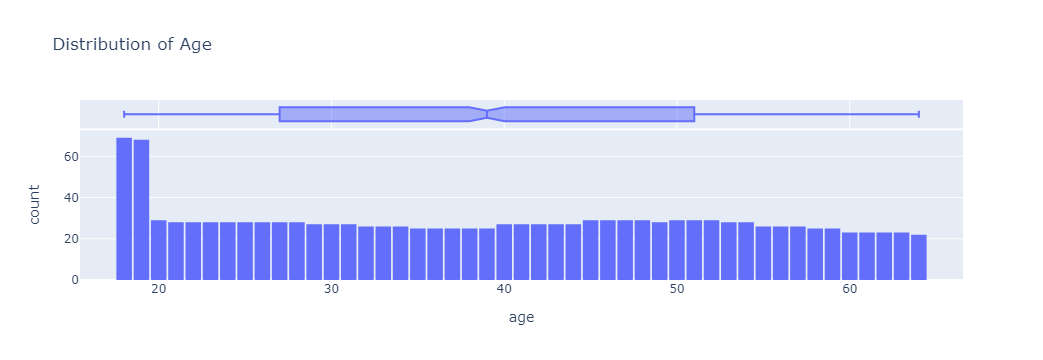

In [19]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)


The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19,
which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the number of people of any given age (between 18 & 64) in the USA.

EXERCISE: Can you explain why there are over twice as many customers with ages 18 and 19, compared to other ages?

???


### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

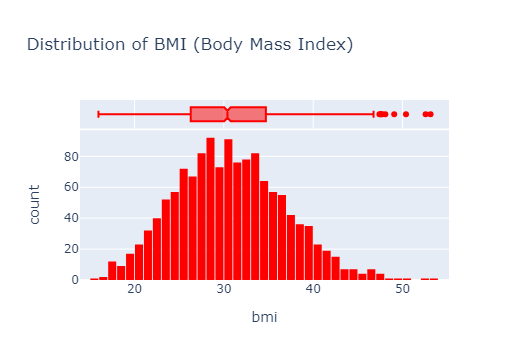

In [20]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a Gaussian distribution centered around the value 30, with a few outliers towards the right. check the link below for interpretation https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html

### Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [21]:
medical_df.charges.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

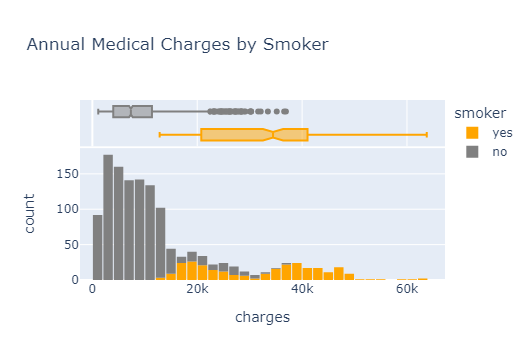

In [39]:
fig = px.histogram(medical_df, 
                   x='charges',
                   marginal='box', 
                   color='smoker',
                   color_discrete_sequence=['orange', 'grey'], 
                   title='Annual Medical Charges by Smoker')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \\$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \\$7300, the median for smokers is close to \\$35,000.


> **EXERCISE**: Visualize the distribution of medical charges in connection with other factors like "sex" and "region". What do you observe?

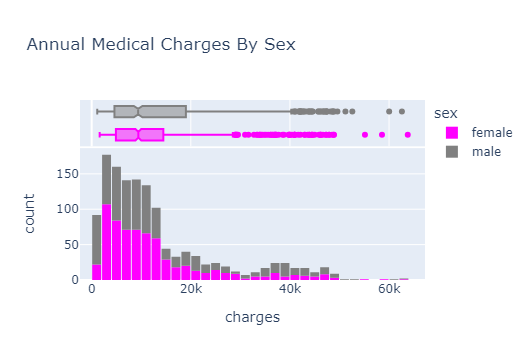

In [38]:
fig = px.histogram(medical_df, 
                   x='charges',
                   marginal='box', 
                   color='sex',
                   color_discrete_sequence=['magenta', 'grey'], 
                   title='Annual Medical Charges By Sex')
fig.update_layout(bargap=0.1)
fig.show()

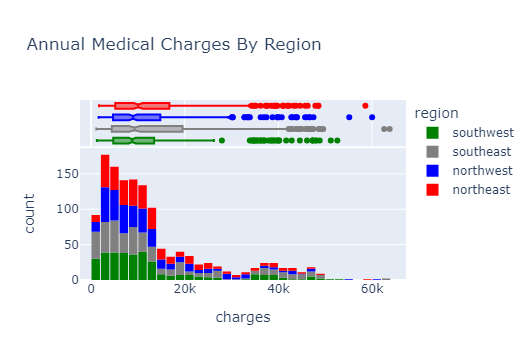

In [35]:
fig = px.histogram(medical_df, 
                   x='charges',
                   marginal='box', 
                   color='region',
                   color_discrete_sequence=['green', 'grey','blue','red'], 
                   title='Annual Medical Charges By Region')
fig.update_layout(bargap=0.1)
fig.show()

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [40]:
medical_df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

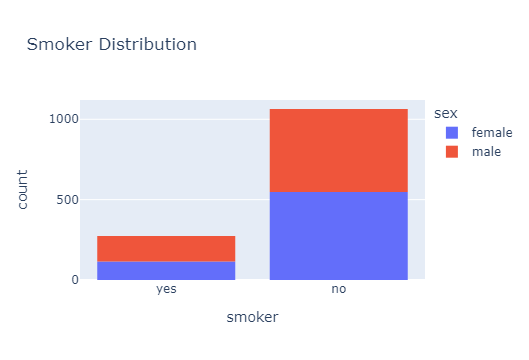

In [42]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker Distribution')